# 필요한 라이브러리

In [2]:
import argparse 
import os
import torch
import torchaudio
import numpy as np
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from wav2vec2_vib import Model
from torchinfo import summary
import librosa

/home/woonj/anaconda3/envs/grad_cam/lib/python3.9/site-packages/pytorch_grad_cam/utils/image.py:10: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.0)
  from scipy.ndimage import zoom


In [2]:
# numpy==1.21.6
# matplotlib==3.5.2

### 모델 및 프로세서 로드

In [3]:
# device = "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(
    device=device,
    ssl_cpkt_path='xlsr2_300m.pt', # https://github.com/facebookresearch/fairseq/blob/main/examples/wav2vec/xlsr/README.md#:~:text=XLS%2DR%20300M-,download,-XLS%2DR%201B
).to(device)
# 가중치 로드 시 에러 핸들링 추가
try:
    model.load_state_dict(torch.load('vib_conf-5_gelu_2s_may27_epoch6.pth', map_location=device))
    print("Model weights loaded successfully!")
except FileNotFoundError:
    print("Model weights file not found. Please check the file path.")
except Exception as e:
    print(f"Error loading model weights: {e}")

/home/woonj/anaconda3/envs/grad_cam/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Model weights loaded successfully!


In [4]:
model

Model(
  (ssl_model): SSLModel(
    (model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU(approximate='none')
          )
          (1-4): 4 x Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU(approximate='none')
          )
          (5-6): 2 x Sequential(
            (0): Conv1d(512, 512, kernel_size=

In [3]:
#ConvFeatureExtractionModel의 마지막 합성곱 레이어
# model.ssl_model.model.feature_extractor.conv_layers[-1][0]

Conv1d(512, 512, kernel_size=(2,), stride=(2,))

In [8]:
model.backend.m_utt_level

Linear(in_features=64, out_features=2, bias=True)

In [9]:
model.LL

Linear(in_features=1024, out_features=128, bias=True)

### 오디오 파일 로드 및 전처리

In [4]:
# 오디오 로드
audio_path = "/home/woonj/grad-cam/1조인성_수상소감.wav"

# 필요한 경우 샘플링 레이트 설정 (None으로 기본 샘플링 레이트 사용)
waveform, sr = librosa.load(audio_path, sr=16000)  # librosa를 사용한다면 이렇게 가능
# waveform = torch.randn(64000)
waveform =  torch.Tensor(waveform)
waveform = waveform.unsqueeze(0)

In [4]:
waveform.shape

torch.Size([1, 85901])

In [20]:
waveform.requires_grad_()  # requires_grad 속성 설정

tensor([[0.0008, 0.0078, 0.0164,  ..., 0.0012, 0.0009, 0.0005]],
       requires_grad=True)

### 타겟 레이어 선택

In [5]:
model.backend.m_frame_level[6]

Linear(in_features=64, out_features=64, bias=True)

In [5]:
target_layer = model.ssl_model.model.feature_extractor.conv_layers[-1][0]
# target_layer = model.ssl_model.model.encoder.layers[23].fc2
# target_layer = model.LL
# target_layer = model.backend.m_frame_level[6]

### CAM 알고리즘 적용

In [6]:
# Grad-CAM 초기화
cam = GradCAM(model=model, target_layers=[target_layer])

call function
forward
torch.Size([1, 85901])
activations_and_gradients - call
torch.Size([1, 85901])
Input tensor shape: torch.Size([1, 1, 85901])
Input tensor shape: torch.Size([1, 512, 17179])
Input tensor shape: torch.Size([1, 512, 8589])
Input tensor shape: torch.Size([1, 512, 4294])
Input tensor shape: torch.Size([1, 512, 2146])
Input tensor shape: torch.Size([1, 512, 1072])
Input tensor shape: torch.Size([1, 512, 536])
Input tensor shape: torch.Size([1, 1024, 268])
compute_cam_per_layer
input_tensor_basecam :  torch.Size([1, 85901])
grads.shape (1, 512, 268)
grads [[[ 1.1273111e-04 -3.2191833e-06  5.7983134e-06 ... -1.5887374e-05
   -1.9026826e-05 -3.2849221e-05]
  [-1.5886006e-04  3.3963792e-05  5.3414802e-05 ...  9.3248833e-05
    3.7940128e-05 -7.1789145e-05]
  [-4.2817037e-06  1.5990516e-06  7.3284599e-07 ...  7.7671228e-07
   -3.6732731e-06 -4.5498232e-06]
  ...
  [-5.8764268e-05 -3.3161388e-05  7.5298522e-07 ... -9.0460089e-06
   -2.6555068e-05  6.5408356e-05]
  [-1.9996589

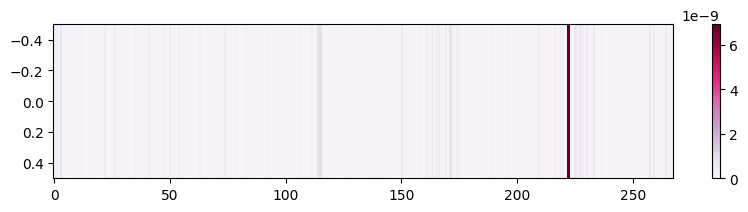

scale_cam_image


In [7]:
grayscale_cam = cam(input_tensor=waveform, targets=None)
# grayscale_cam = grayscale_cam[0, :]

In [12]:
grayscale_cam.shape

torch.Size([1, 268])

### 시각화

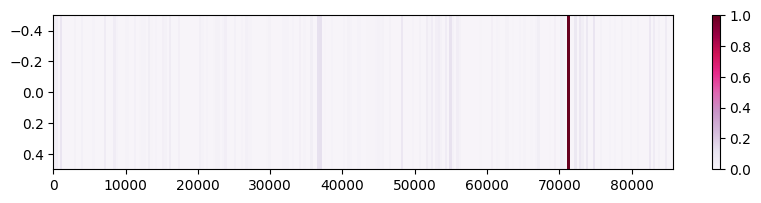

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `normalized_tensor` is the tensor you've normalized and is now in the range [0, 1]
# Scale the tensor to have a maximum of 320
scaled_tensor_np = grayscale_cam.detach().numpy()
# Set the number of pixels for each value
pixel_per_value = 320

# Create a new array with expanded width
expanded_heatmap = np.repeat(scaled_tensor_np, pixel_per_value, axis=1)

# Create the heatmap
plt.figure(figsize=(10, 2))  # Set the size of the heatmap
plt.imshow(expanded_heatmap, cmap='PuRd', interpolation='nearest', aspect='auto')  # Generate the heatmap
plt.colorbar()  # Add color bar
plt.show()